# Les séries temporelles avec Python (2/4)

>1. Introduction à la manipulation de données temporelles avec Python
>2. **Visualisation et opérations sur les séries temporelles**
>3. Éléments théoriques et exemples
>4. Analyse, modélisation et prédiction

Ce second article sur les séries temporelles s'intéresse à la visualisation et aux opérations que l'ont peut effectuer sur les objets séries temporelles avant de conclure sur une petite étude de cas simple en utilisant les outils présentés dans ces 2 premiers posts.

# Visualisation et opérations sur les séries temporelles

## Un peu d'anglicisme : Resampling, Shifting, and Windowing

- *Resampling* = rééchantillonnage
- *Shifting* = déplacement
- *Windowing* = fenêtrage

La capacité à utiliser les dates/times comme indices pour organiser et accéder aux données est une point important des outils de séries temp sur Pandas. Les avantages de l'indexation (alignement, slicing, etc...) sont conservés et Pandas fournit par ailleurs plusieurs opérations spécifiques séries temp (séries temp désignent ici une `Series` indexées par un `DatetimeIndex`, en général).

On va en voir quelques unes en utilisant en exemple le cours de l'action Google en bourse (données récupérées sur Yahoo finance).

> **Petit exo :**
>- importer les données `GOOG.csv` en utilisant les bons paramètres pour avoir un DatetimeIndex à partir de la colonne indiquant les dates
>- ne conserver que la série 'Close' qui correspond au prix de l'action à la fermeture
>- afficher la série

In [31]:
goog = pd.read_csv('data/GOOG.csv', index_col='Date', parse_dates=True)
goog.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
2004-08-26,52.279045,53.773445,52.134586,53.753517,53.753517,7128600
2004-08-27,53.848164,54.107193,52.647663,52.876804,52.876804,6241200
2004-08-30,52.443428,52.548038,50.814533,50.814533,50.814533,5221400
2004-08-31,50.958992,51.661362,50.889256,50.993862,50.993862,4941200


In [32]:
goog.index

DatetimeIndex(['2004-08-19', '2004-08-20', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-30',
               '2004-08-31', '2004-09-01',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-26', '2020-05-27',
               '2020-05-28', '2020-05-29'],
              dtype='datetime64[ns]', name='Date', length=3972, freq=None)

In [33]:
goog = goog['Close']
goog

Date
2004-08-19      49.982655
2004-08-20      53.952770
2004-08-23      54.495735
2004-08-24      52.239193
2004-08-25      52.802086
                 ...     
2020-05-22    1410.420044
2020-05-26    1417.020020
2020-05-27    1417.839966
2020-05-28    1416.729980
2020-05-29    1428.920044
Name: Close, Length: 3972, dtype: float64

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set() #pour définir les paramètres d'affichage de seaborn par défaut
plt.rcParams["figure.figsize"] = (12,8)

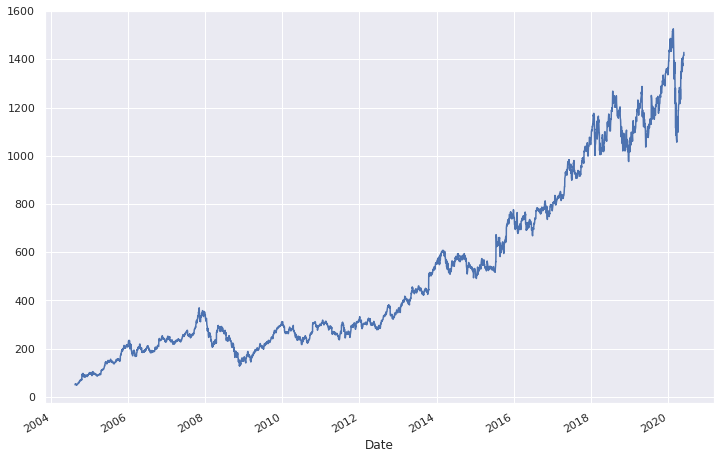

In [35]:
goog.plot();

### Rééchantillonage et conversion de fréquences

Une manipulation classique des séries temporelles est le rééchantionnage (resampling) à une fréquence plus ou moins haute. Il y a pour ce faire les méthodes `resample()` ou `asfreq()`. La différence entre les deux est que `resample` consiste à agréger toutes les données comprises entre 2 multiples de la fréquence alors que `asfreq` sélectionne la valeur correspondant à la fréquence.

> **Petit exo :**
>- Regarder la différence entre les 2 affichant sur un même grapique les 3 séries 'close', 'resample' et 'asfreq' en choisissant la fréquence que vous voulez

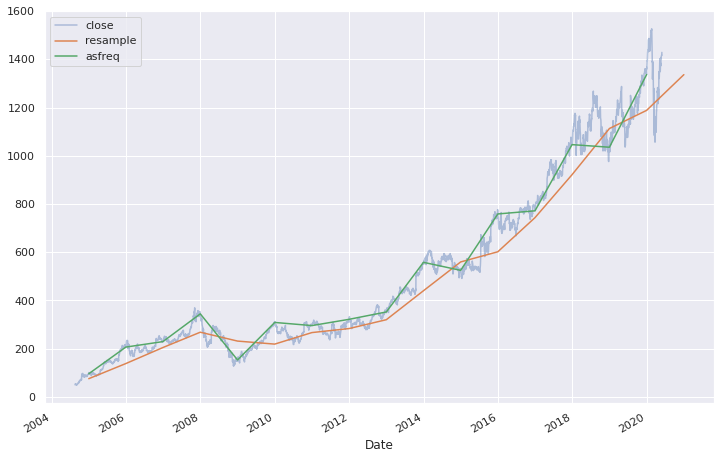

In [36]:
goog.plot(alpha=0.4)
goog.resample('BA').mean().plot()
goog.asfreq('BA').plot();
plt.legend(['close', 'resample', 'asfreq'], loc='upper left');

Pour un resampling avec une fréquence plus importante, `resample()` et `asfreq()` sont équivalentes. Par défaut, les 2 méthodes laissent les valeurs non existantes vides. Toutefois, `asfreq()` accepte un paramètre `method` dans lequel on peut spécifier comment imputer les valeurs manquantes générées par l'augmentation de la fréquence.

> **Petit exo :**
>- Selectionner uniquement les 14 derniers jours
>- Faire un resampling de la série GOOG.csv avec une fréquence quotidienne, ça incluera donc les weekends)
>- Afficher pour chaque méthode (`resample()` et `asfreq()`) les courbes rééchatillonnées sans imputer les valeurs manquantes, avec une imputation de type "bfill" et une imputation de type "ffill" (donc 2x3 courbes)

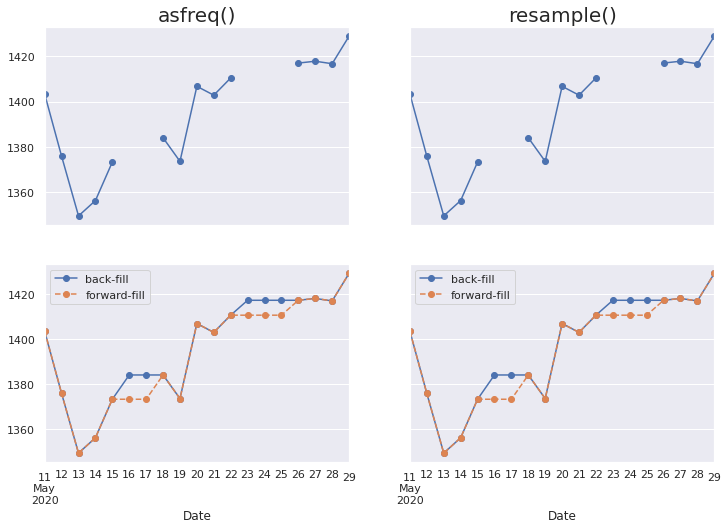

In [37]:
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
data = goog.iloc[-14:]

#avec asfreq
data.asfreq('D').plot(ax=ax[0,0], marker='o')
ax[0,0].set_title("asfreq()", fontsize=20);

data.asfreq('D', method='bfill').plot(ax=ax[1,0], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1,0], style='--o')
ax[1,0].legend(["back-fill", "forward-fill"]);

#avec resample
data.resample('D').mean().plot(ax=ax[0,1], marker='o')
ax[0,1].set_title("resample()", fontsize=20);

data.resample('D').bfill().plot(ax=ax[1,1], style='-o')
data.resample('D').ffill().plot(ax=ax[1,1], style='--o')
ax[1,1].legend(["back-fill", "forward-fill"]);

### Déplacements

Une opération classique sur les séries temporelles est le déplacement ou décalage (on parle plus souvent de *time-shifts* ou *shifting*)

Deux méthodes sont prévues pour ça : `shift()` et `tshift()`. Pour faire court, la différence entre les deux est que `shift()` déplace les données alors que`tshift()` déplace les index. Dans les 2 cas, le décalage doit être un multiple de la fréquence.

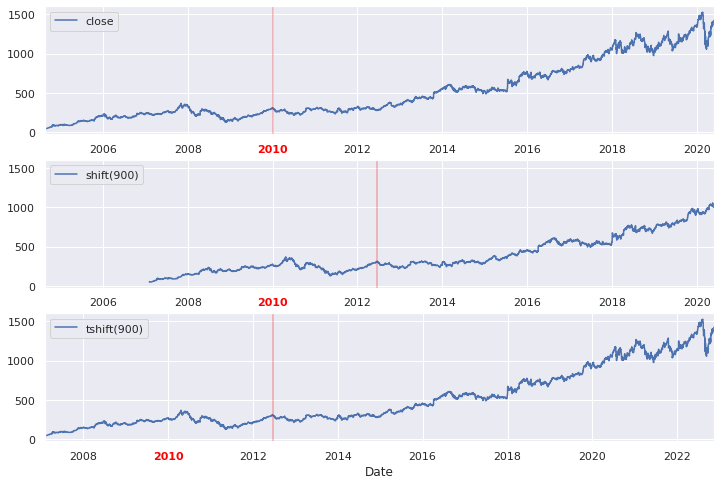

In [38]:
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
goog = goog.asfreq('D', method='ffill')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2010-01-01')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['close'], loc=2)
ax[0].get_xticklabels()[3].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[3].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[2].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

>**Petit exo :**
>- Utiliser le *shifting* pour calculer le retour sur investissement à 1 an de l'action de Google (ROI - *return on investment*)
>- Tracer la série temporelle ROI ainsi créée
>- Analyser (rapidement) la courbe obtenue

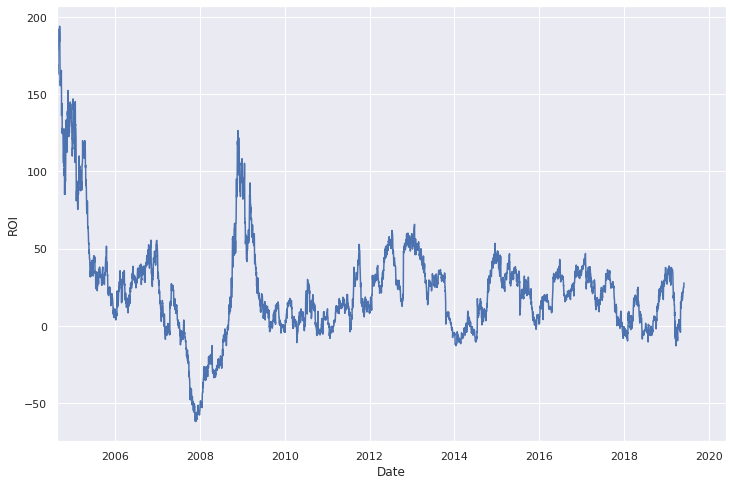

In [39]:
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.iloc[365:].plot()
plt.ylabel('ROI');

### Attention, fenêtres glissantes

Enfin, la 3ème opération classique des séries temporelles consiste à calculer différentes statistiques sur une fenêtre d'une longueur donnée et qui se déplace. On parle de *rolling window* et pas vraiment de fenêtre glissante...et pour faire ça, Pandas fournit la méthode `rolling()` pour les objets `Series` et `DataFrame`. 

> **Petit exo :**
>- Utiliser la méthode rolling pour calculer la moyenne annuelle centrée et l'écart-type annuel centré
>- Afficher sur un même graphique les 3 courbes : 'close', 'moyenne' et 'std'

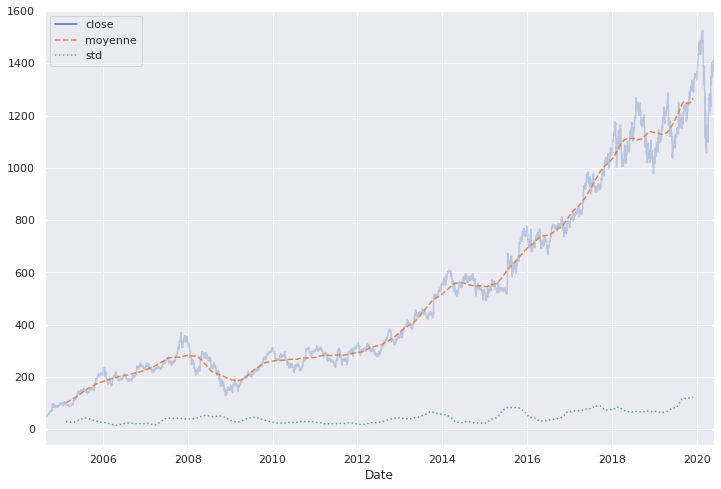

In [40]:
rol = goog.rolling(365, center=True)

data = pd.DataFrame({'close': goog,
                     'moyenne': rol.mean(),
                     'std': rol.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

## Un exemple de visualisation : le nombre de vélos à Paris Montparnasse

On va terminer sur un petit exemple un peu plus parlant, ou en tout cas, un peu moins financier : on va regarder le nombre de vélo passés par un des compteurs de la ville de Paris, situé sur le boulevard Montparnasse. Le jeu de données vient [de là](https://opendata.paris.fr/explore/dataset/comptage-velo-donnees-compteurs/information/?disjunctive.id_compteur&disjunctive.nom_compteur&disjunctive.id&disjunctive.name). Le décompte horaire des vélos peut ainsi être récupéré.

**"Petit" exo :**
1. Importer le dataset
2. Le nettoyer un peu : supprimer les colonnes inutiles, modifier les entêtes à rallonge, gérer les formats de dates (tout ça peut être fait dans à l'aide des paramètres de `read_csv`)
3. Définir, si ce n'est pas déjà fait, la série temporelle des décomptes horaires de vélos et l'afficher
4. Ne conserver que les données après la zone de valeurs manquantes début 2019
5. Regarder quelques statistiques générales avec un `describe`
6. Visualisation de la tendance :
>- la série par heure étant trop "dense" pour être clairement lisible, on va diminuer la fréquence : utiliser `resample` pour faire la somme des vélos sur une journée et sur une semaine puis réafficher les deux séries obtenues dans une même figure sur deux objets `axes` différents. Commentez le graphique ainsi obtenu.
>- à l'aide de la méthode `rolling` calculer la moyenne mobile mensuelle (donc sur 30 jours !). Le refaire avec le paramètre `win_type="gaussian"` et superposer les deux séries sur un même graphique.
8. Après avoir vu la tendance, on veut regarder la répartition quotidienne et hebdomadaire du trafic :
>- à l'aide de la méthode `groupby` ainsi que des attributs `time` et `dayofweek` des objets `DatetimeIndex`, calculer le nombre moyen de vélos décomptés pour chaque heure de la journée et pour chaque jour de la semaine. Afficher les 2 séries obtenues et les commenter
>- enfin, plus compliqué pour terminer, regarder les nombres moyens de vélos par heure de la journée selon qu'on est un jour ouvrable ou jour de weekend et afficher les 2 séries puis les commenter.

In [41]:
velo = pd.read_csv('data/comptage-velo-montpar.csv', sep=';',
                   names=["nb", "date"], header=0,
                   usecols=[4,5])
velo.head(10)

,nb,date
0,75,2019-04-25T09:00:00+02:00
1,101,2019-04-25T19:00:00+02:00
2,0,2019-04-27T05:00:00+02:00
3,27,2019-04-27T11:00:00+02:00
4,24,2019-04-27T16:00:00+02:00
5,29,2019-04-28T20:00:00+02:00
6,75,2019-04-29T09:00:00+02:00
7,103,2019-04-29T18:00:00+02:00
8,19,2019-04-29T23:00:00+02:00
9,77,2019-04-30T09:00:00+02:00


In [42]:
pd.DatetimeIndex(pd.to_datetime(velo.date, utc=True)).tz_convert('Europe/Paris').tz_localize(None)

DatetimeIndex(['2019-04-25 09:00:00', '2019-04-25 19:00:00',
               '2019-04-27 05:00:00', '2019-04-27 11:00:00',
               '2019-04-27 16:00:00', '2019-04-28 20:00:00',
               '2019-04-29 09:00:00', '2019-04-29 18:00:00',
               '2019-04-29 23:00:00', '2019-04-30 09:00:00',
               ...
               '2019-04-25 05:00:00', '2019-04-25 21:00:00',
               '2019-04-28 21:00:00', '2019-04-30 19:00:00',
               '2019-05-01 10:00:00', '2019-05-04 02:00:00',
               '2019-05-05 12:00:00', '2019-05-06 10:00:00',
               '2019-05-07 12:00:00', '2019-05-07 15:00:00'],
              dtype='datetime64[ns]', name='date', length=19391, freq=None)

In [43]:
velo = pd.read_csv('data/comptage-velo-montpar.csv', sep=';',
                   names=["nb", "date"], header=0,
                   usecols=[4,5],
                   index_col="date",
                   parse_dates=False,
                   date_parser=lambda s: pd.to_datetime(s.split("+")[0])
                  )
velo.head()

,nb
date,
2019-04-25 09:00:00,75
2019-04-25 19:00:00,101
2019-04-27 05:00:00,0
2019-04-27 11:00:00,27
2019-04-27 16:00:00,24


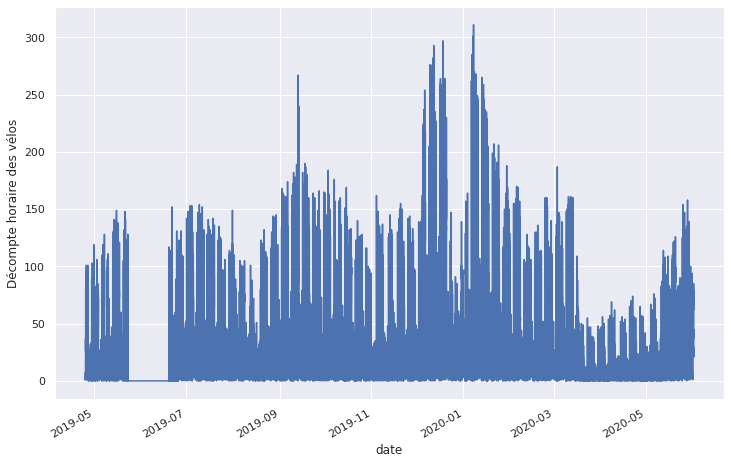

In [44]:
velo.plot(legend=False)
plt.ylabel('Décompte horaire des vélos');

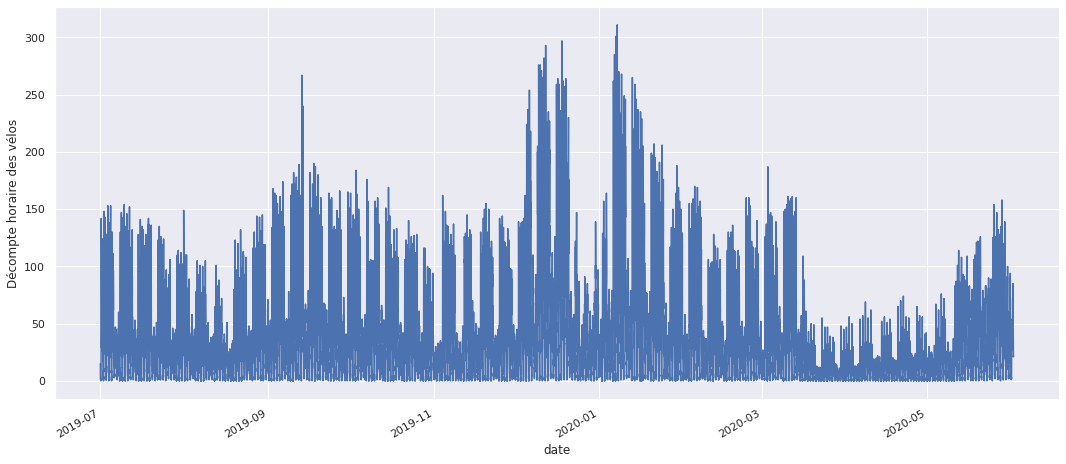

In [45]:
velo = velo["2019-07":]
velo.plot(legend=False, figsize=(18,8))
plt.ylabel('Décompte horaire des vélos');

In [46]:
velo.describe()

,nb
count,16175.000000
mean,34.649645
std,38.728829
min,0.000000
25%,7.000000
50%,23.000000
75%,47.000000
max,311.000000


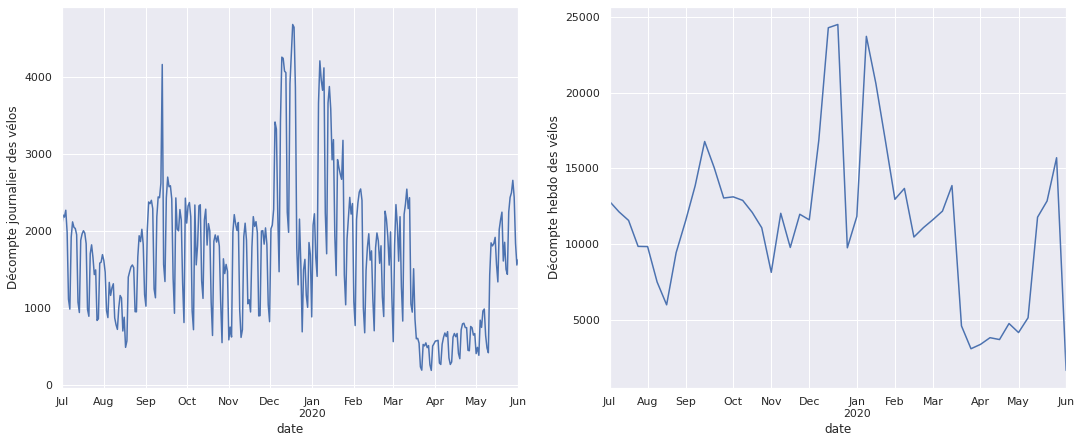

In [47]:
fig, ax = plt.subplots(1,2,figsize=(18,7))

velo_jr =  velo.resample('D').sum()
velo_jr.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Décompte journalier des vélos');

velo_sem =  velo.resample('W').sum()
velo_sem.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Décompte hebdo des vélos');

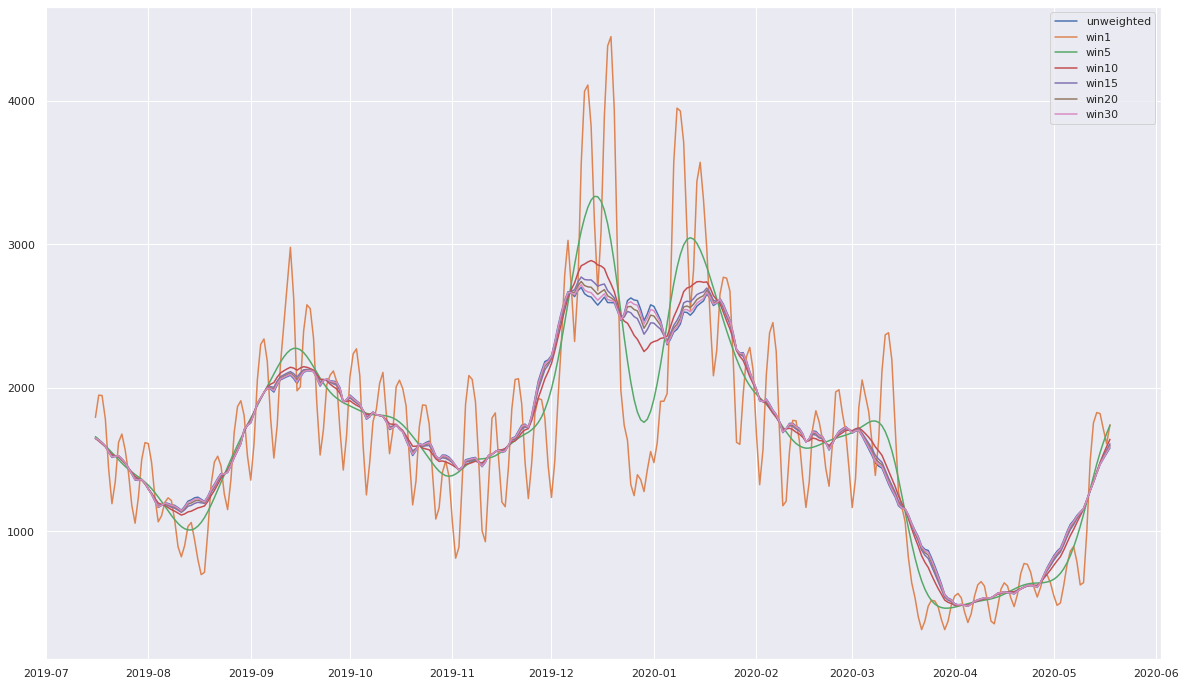

In [48]:
plt.figure(figsize=(20,12))
plt.plot(velo_jr.rolling(30, center=True).mean(),label="unweighted")
#ax=plt.gca()
for std in [1,5,10,15,20,30]:
    plt.plot(velo_jr.rolling(30, center=True, win_type='gaussian').mean(std=std), label=f"win{std}")

plt.legend(loc='best');

In [49]:
velo.index.dayofweek

Int64Index([0, 0, 0, 3, 3, 4, 4, 5, 0, 0,
            ...
            4, 4, 5, 5, 6, 6, 6, 6, 6, 0],
           dtype='int64', name='date', length=16175)

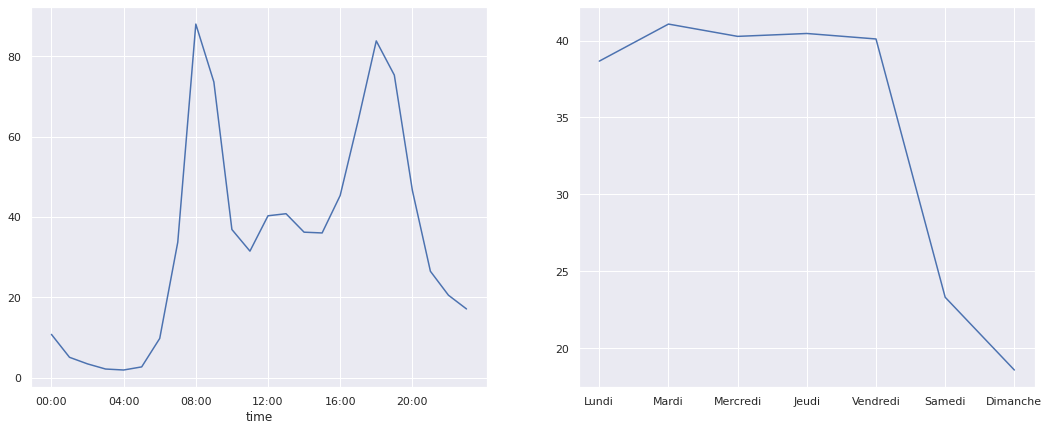

In [50]:
fig, ax = plt.subplots(1,2,figsize=(18,7))

par_hr = velo.groupby(velo.index.time).mean()
heures = 4 * 60 * 60 * np.arange(6)
par_hr.plot(ax=ax[0], xticks=heures, legend=False);

par_sem = velo.groupby(velo.index.dayofweek).mean()
par_sem.index = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
par_sem.plot(ax=ax[1], legend=False);

In [51]:
jours_ouvrables = np.where(velo.index.weekday < 5, 'Ouvrable', 'Weekend')
par_hr = velo.groupby([jours_ouvrables, velo.index.time]).mean()

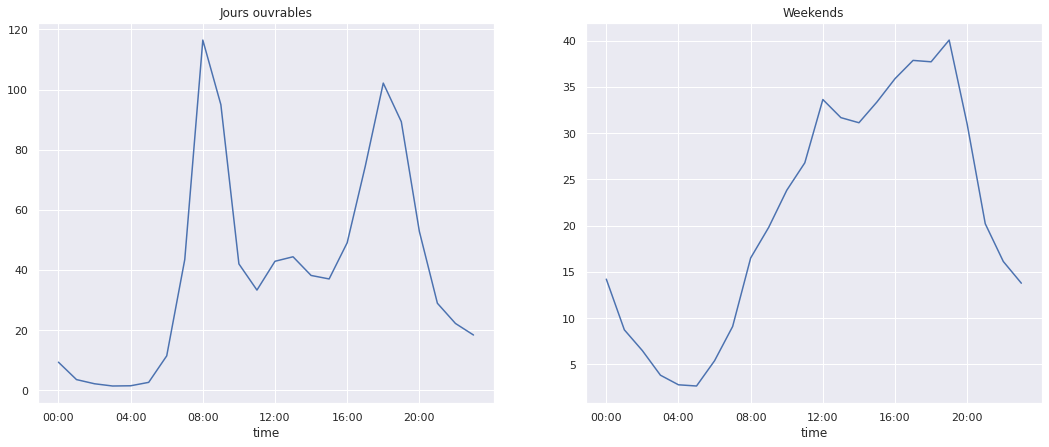

In [52]:
fig, ax = plt.subplots(1,2,figsize=(18,7))
par_hr.loc['Ouvrable'].plot(ax=ax[0], title='Jours ouvrables', xticks=heures, legend=False)
par_hr.loc['Weekend'].plot(ax=ax[1], title='Weekends', xticks=heures, legend=False);